## Conceptual Overview

A control node has a set of functions that allow it to take **sensory information**, compare it to a target **reference**, and compute an **error** signal, which can then drive a control **command**. Control thus creates changes in states and the sensor observes the new state. Optionally, error can be used to update reference and control mechanisms.

_TODO: update mechanism for internal model_


`Node(inputs, behavioral_model, system_estimate, reference, reference_update, sensor_function, comparator_function, controller_update, internal_model_update)`
<br/>

**inputs** - source of inputs (i.e. environment, state observations, others behaviors)

**behavioral model** - initial matrix expressing future state given last behavior ("B" matrix)

**system estimate** - initial matrix expressing future state given last state ("A" matrix)

**reference** - target state 

**reference update** - update to reference (target) signal

**sensor function** - for taking in (and processing) observations

**comparator function** - for comparing observation and estimate

**controller** - for generating output

**controller update** - for updating the behavioral matrix 

**internal model** - for generating forward prediction

**internal model update** - for updating the system estimate 
<br/>


![IMC](control.png)

#### Experiment
In the below experiment a blue agent/node pursues a static red reference goal, with the plant implemented as a separate node, translating commands into state transitions. The agent perceives the new state and acts accordingly. 

In [1]:
from Node.Node import Control_node
from Node.functions import *
import numpy as np
import time
import pylab as pl
from IPython import display
import matplotlib.pyplot as plt

In [2]:
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
B1 = np.array([[.1,0],
               [0,0.1]])
B2 = np.array([[0,0],
               [0,0]])

# state/system matrix (maps previous state to future state - how will others behave (give past behaviors)?)
A1 = np.array([[0.4,0],
               [0,0.4]])
A2 = np.array([[0.4,0],
               [0,0.4]])

# reference matrix (how do I expect/want others to behave? target values)
R1 = np.array([0.3,0.7])
R2 = np.array([0,0])

# Initial behavior
behav_1 = np.array([0.6,0.6])


# get the state observation (behaviors of others)
def sense(inputs):
    return inputs

# contrast reference with observations (and potentially incorporate predictions from internal model)
def compare(sensory_signal, reference, prediction):
    error = reference - sensory_signal
    return error

# generate a behavior
def control(error, behavioral_model, previous_output):
    #output = np.array([behavioral_model[i][i]*error[i] for i in range(len(error))])
    output = behavioral_model @ error
    return output


# adjusts behavioral model to get closer to behavior given 
def control_update(error, behavioral_model, previous_output):
    # LMS algorithm
    learning_rate = 0.0
    #behavioral_model = behavioral_model + learning_rate * error * previous_output
    return behavioral_model

# generate predictions on next state
def imc(system_estimate, previous_state, behavioral_model, previous_output):
    # actual estimate
    state = (system_estimate @ previous_state) + (behavioral_model @ previous_output)
    return state

# adjust system estimate to infer observations given my behavior
def imc_update(inputs, system_estimate, previous_behavior, behavioral_model, previous_state, learning_rate):
    # actual estimate
    curr_system_est = (system_estimate @ previous_state) + (behavioral_model @ previous_behavior)
    error = curr_system_est - inputs
    #learning_rate = 0.01
    system_estimate = system_estimate + learning_rate * error * previous_behavior
    return system_estimate

# agent two acts as the plant (error = control output)
def plant_control(error, behavioral_model, previous_output):
    output = previous_output + error
    return output

# just get the control output
def plant_compare(sensory_signal, reference, prediction):
    error = sensory_signal
    return error





agent1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, system_estimate=A1, reference=R1, init_behavior=behav_1)
plant = Control_node(sensor=sense, comparator=plant_compare, control_update=control_update,  controller = plant_control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, system_estimate=A2, reference=R2, init_behavior=behav_1)

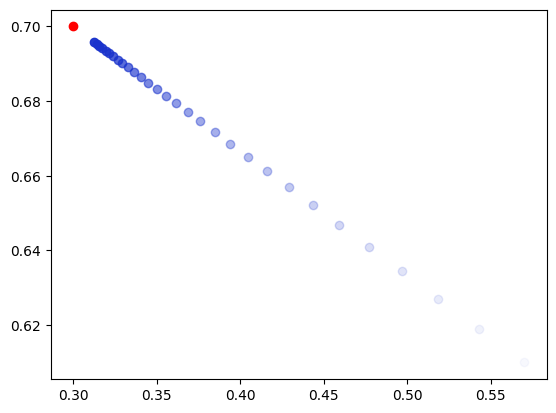

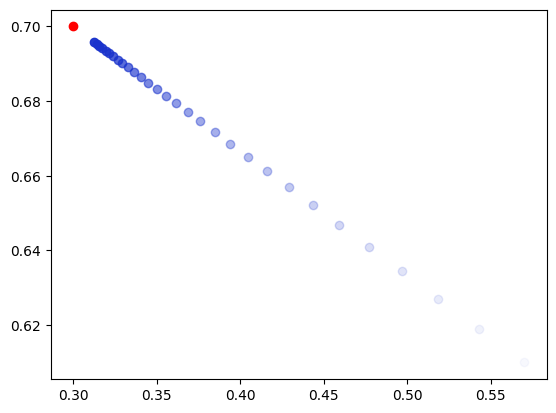

In [3]:
%matplotlib inline
trials = 30
#time = [n for n in range(trials)]
color = (0.1,0.2,0.8,0.1)
behavior1 = np.array([0,0])
controller_error = []
agent1_behaviors = []
plant_outputs = []

state = np.array([0.6,0.6])
agent1_error = []

pl.scatter(R1[0],R1[1], c='red')
for t in range(trials):
    b1 = agent1.go(state)   
    plant_output = plant.go(b1)

    agent1_behaviors.append(agent1.get_output())
    plant_outputs.append(plant.get_output())
    controller_error.append(agent1.get_error())
    agent1_error.append(sum(abs(agent1.get_error())/len(agent1.get_error())))

    behavior1 = b1
    state = plant_output
    
    color = [0.1,0.2,0.8, (t+1)/(trials+1)]
    pl.scatter(plant_output[0],plant_output[1],c=tuple(color))
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(0.5)

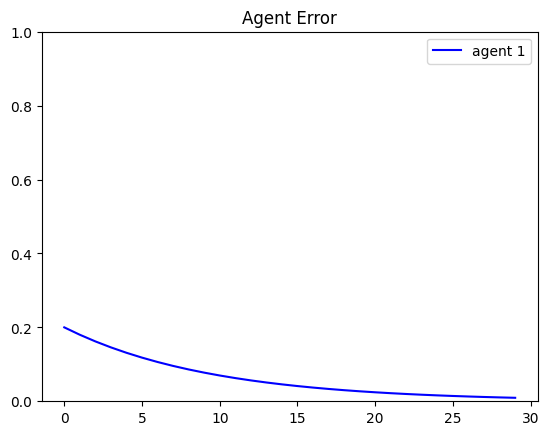

In [5]:

t = [n for n in range(trials)]
plt.plot(t, agent1_error, 'b',label="agent 1")
plt.ylim([0, 1])
plt.legend()
plt.title("Agent Error")
plt.show()



## Control

In the above experiment a node/agent pursues a static target, with the plant implemented as a separate node, simply translating commands into transitions in state. The agent is able to observe the transition and act accordingly.

A "plant" is deliberately not included in the nodes as the role of plant as an internal translator of state (as above) or as an external system is up to the user. That is, a controller might transition from state to state using just the controller, but the plant might actually be an external system (e.g. another agent).

![IMC](internal_external.png)

## Agents

Here we consider a case in which two agents/nodes are interacting. Controllers update their own position, but they only observe the behavior/state of their counterpart. As an example, agents here will share the same reference/goal state and will exert control by randomly adjusting their positions relative to the magnitude of perceived error. That is, if the counterpart is off, the agent will adjust their behavior considerably.

Agent behavior is only adjusted along the x axis and is displayed with space along the y axis for visual demonstration purposes. The important takeaway here is that agent errors tends to mirror eachother: **my error depends on yours**.

![IMC](agents.png)

In [17]:
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
B1 = np.array([0.2])
B2 = np.array([0.2])

# state/system matrix (maps previous state to future state - how will others behave (give past behaviors)?)
A1 = np.array([1])
A2 = np.array([1])

# reference matrix (how do I expect/want others to behave? target values)
R1 = np.array([0.5])
R2 = np.array([0.5])

# Initial behavior
behav_1 = np.array([0.8])
behav_2 = np.array([0.2])


# get the state observation (behaviors of others)
def sense(inputs):
    return inputs

# contrast reference with observations (and potentially incorporate predictions from internal model)
def compare(sensory_signal, reference, prediction):
    error = reference - sensory_signal
    return error

# generate a behavior
def control(error, behavioral_model, previous_output):
    output = chaotic_update(previous_output, 0.05, error)
    return output


# adjusts behavioral model to get closer to behavior given 
def control_update(error, behavioral_model, previous_output):
    # LMS algorithm
    learning_rate = 0.0
    #behavioral_model = behavioral_model + learning_rate * error * previous_output
    return behavioral_model

# generate predictions on next state
def imc(system_estimate, previous_state, behavioral_model, previous_output):
    # actual estimate
    state = (system_estimate @ previous_state) + (behavioral_model @ previous_output)
    return state

# adjust system estimate to infer observations given my behavior
def imc_update(inputs, system_estimate, previous_behavior, behavioral_model, previous_state, learning_rate):
    # actual estimate
    curr_system_est = (system_estimate @ previous_state) + (behavioral_model @ previous_behavior)
    error = curr_system_est - inputs
    #learning_rate = 0.01
    system_estimate = system_estimate + learning_rate * error * previous_behavior
    return system_estimate
    





agent1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, system_estimate=A1, reference=R1, init_behavior=behav_1)
agent2 = Control_node(sensor=sense, comparator=compare, control_update=control_update,  controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, system_estimate=A2, reference=R2, init_behavior=behav_2)


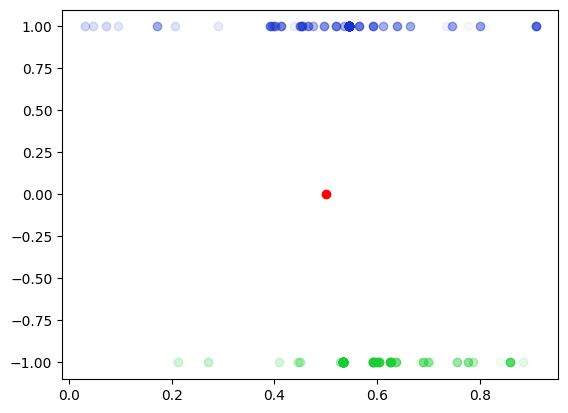

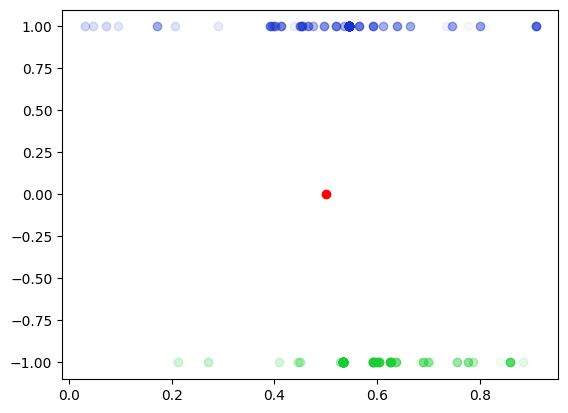

In [18]:
%matplotlib inline
trials = 50
color = (0.1,0.2,0.8,0.1)
agent1_behaviors = []
agent2_behaviors = []
agent1_error = []
agent2_error = []

b1 = behav_1
b2 = behav_2

pl.scatter(R1[0],0, c='red')
for t in range(trials):
    b1_temp = agent1.go(b2)   
    b2_temp = agent2.go(b1)

    agent1_behaviors.append(agent1.get_output())
    agent2_behaviors.append(agent2.get_output())

    agent1_error.append(np.absolute(agent1.get_error()))
    agent2_error.append(np.absolute(agent2.get_error()))
    #agent1_error.append(sum(abs(agent1.get_error())/len(agent1.get_error())))

    b1 = b1_temp
    b2 = b2_temp
    
    color1 = [0.1,0.2,0.8, (t+1)/(trials+1)]
    color2 = [0.1,0.8,0.2, (t+1)/(trials+1)]
    pl.scatter(b1[0],1,c=tuple(color1))
    pl.scatter(b2[0],-1,c=tuple(color2))
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(0.5)

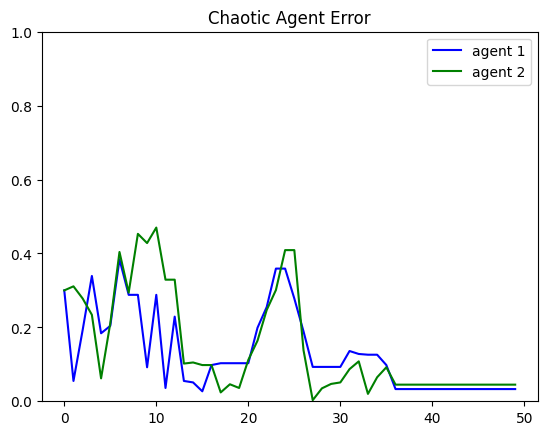

In [19]:

t = [n for n in range(trials)]
plt.plot(t, agent1_error, 'b',label="agent 1")
plt.plot(t, agent2_error, 'g', label="agent 2")
plt.ylim([0, 1])
plt.legend()
plt.title("Chaotic Agent Error")
plt.show()



## Hierarchy

![IMC](hierarchy.png)